In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Importing relevant packages:

In [414]:
import os
import numpy as np
import pandas as pd
import glob
from pickleshare import PickleShareDB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dropout, SimpleRNN
from tensorflow.keras.layers import Bidirectional, LSTM, RepeatVector, Dense
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
import datetime
import scikitplot as skplt
from tensorflow.keras.layers import LeakyReLU

Setting the appropriate working directory for the data:

In [3]:
os.getcwd()
os.chdir('C:\\Users\\Wyatt\\Documents\\Assignment4')

'C:\\Users\\Wyatt\\Downloads'

Loading the data:

In [4]:
db4=PickleShareDB('movies/assign4.pshare')

db4.keys() #data in db4

['emMat10000X100',
 'wordIndx',
 'X_Test',
 'X_Train',
 'X_Val',
 'y_Test',
 'y_Train',
 'y_Val']

In [5]:
[key for key in db4['wordIndx'].keys()][:12] #wordIndx keys

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that']

In [427]:
# Some params
maxWords=10000 #max number of words
emDim=100 #dimension of GloVe file, 
maxLen=80 #max length of review, input length
emMat=db4['emMat10000X100']

In [7]:
tf.keras.backend.clear_session()   # clearing previous models

## Baseline Sequential Model

In [8]:
# Creating a baseline model

model0 = Sequential()
model0.add(Embedding(maxWords,emDim,input_length=maxLen))
model0.add(Flatten())
model0.add(Dense(64,activation='relu'))
model0.add(Dense(1,activation='sigmoid'))

In [9]:
model0.layers[0].set_weights([emMat])  # adding the embedding matrix
model0.layers[0].trainable=False       # making the layer un-trainable

In [10]:
model0.summary() # model summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 100)           1000000   
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                512064    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,512,129
Trainable params: 512,129
Non-trainable params: 1,000,000
_________________________________________________________________


Creating objects for the data from db4:

In [11]:
X_Train=db4['X_Train']
y_Train=db4['y_Train']
X_Val=db4['X_Val']
y_Val=db4['y_Val']

In [12]:
X_Train.shape # checking the shape of the data in X_train

(2000, 80)

In [13]:
# Compiling the model

model0.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [437]:
%load_ext tensorboard 

ModuleNotFoundError: No module named 'tensorboard '

In [15]:
log_dir='/tf_logs/run1'   # Explicit specificying the directory for the model results to be output to

tensorflow_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                  histogram_freq=1)

In [16]:
#fitting the model to the training data, using 30 epochs

history=model0.fit(X_Train, y_Train,
        epochs=30,
        batch_size=32,
        validation_data=(X_Val,y_Val),
        verbose=0,
        callbacks=[tensorflow_callback])
model0.save_weights('assign-4-pretrained-test-1.h5')

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


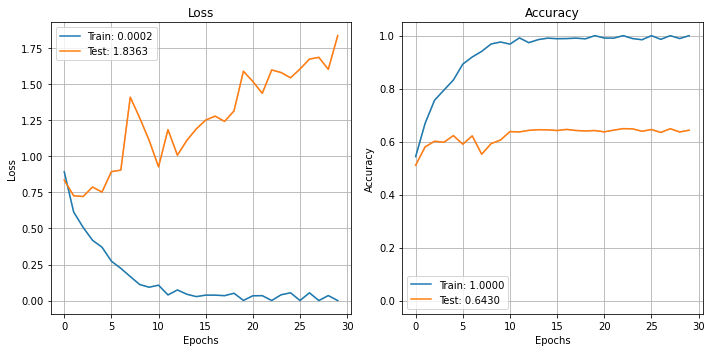

In [17]:
plot_history(history.history)   # plotting the above model

The above model has an overfitting issue. While the training loss drops to .0379 and shows a significant downwards trend over epochs, the testing loss is 1.4155 and shows an upward trend. While accuracy seems to stabilize for the testing data around .64 which is better than a coin flip, the loss suggests significant overfitting. To combat this, I will add a dropout layer with a .3 parameter.

In [18]:
modeld1 = Sequential()
modeld1.add(Embedding(maxWords,emDim,input_length=maxLen))
modeld1.add(Flatten())
modeld1.add(Dropout(.3)) #addition to the baseline model
modeld1.add(Dense(64,activation='relu'))
modeld1.add(Dense(1,activation='sigmoid'))
modeld1.layers[0].set_weights([emMat])
modeld1.layers[0].trainable=False

In [19]:
modeld1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 100)           1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                512064    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,512,129
Trainable params: 512,129
Non-trainable params: 1,000,000
_________________________________________________________________


In [20]:
# Compiling the new model

modeld1.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [21]:
log_dir='/tf_logs/run2' #for output of results to specified directory

tensorflow_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                  histogram_freq=1)

In [22]:
# Training the new model, also over 30 epochs

history=modeld1.fit(X_Train, y_Train,
        epochs=30,
        batch_size=32,
        validation_data=(X_Val,y_Val),
        verbose=0,
        callbacks=[tensorflow_callback])
modeld1.save_weights('assign-4-dropout-pretrained-test-1.h5')

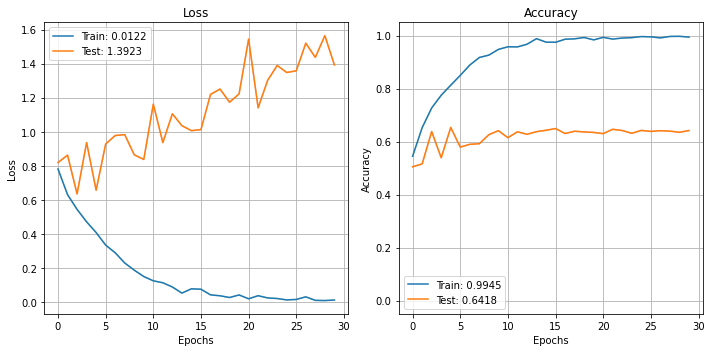

In [23]:
plot_history(history.history)   # this is from plot_keras_history

This model also demonstrates significant overfitting and suggests that a sequential model may be inapproriate for the model. I will clear the session and use a simple RNN with dropout equal to .2 and recurrent dropout equal to .2 to minimize overfitting.

## Developing an RNN Model

In [24]:
tf.keras.backend.clear_session()

In [25]:
modelRNN1=Sequential()
modelRNN1.add(Embedding(maxWords,emDim,input_length=maxLen))
modelRNN1.add(Bidirectional(SimpleRNN(64,dropout=0.20, recurrent_dropout=0.20)))
modelRNN1.add(Dense(1,activation='sigmoid'))
modelRNN1.layers[0].set_weights([emMat])
modelRNN1.layers[0].trainable=False

In [26]:
log_dir='tf_logs/run3'

tensorflow_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                  histogram_freq=1)

In [27]:
# Compiling the model

modelRNN1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [28]:
# Training the RNN model

history=modelRNN1.fit(X_Train, y_Train,
        epochs=30,
        batch_size=32,
        validation_data=(X_Val,y_Val),
        verbose=0,
        callbacks=[tensorflow_callback])
modelRNN1.save_weights('assign-4-RNN1-pretrained-test-1.h5')

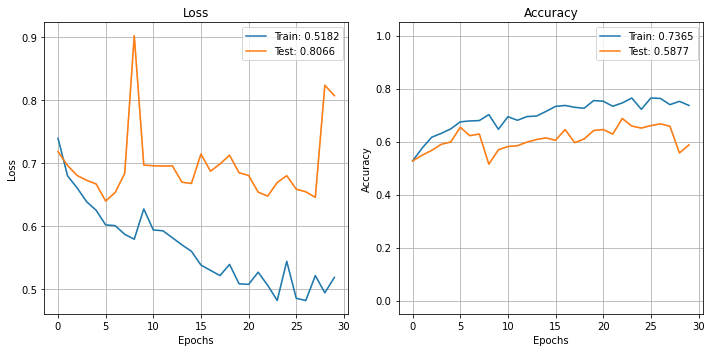

In [29]:
plot_history(history.history)   # plotting the RNN model

Loss is signficantly reduced for the testing here and there is a corresponding increase in testing accuracy. However, the increase in accuracy from the baseline sequential model is minimal and there is still evidence of overfitting. I will increase dropout and recurrent dropout in the following model to further reduce the opportunity for overfitting.

In [30]:
tf.keras.backend.clear_session()

In [31]:
log_dir='tf_logs/run4'

tensorflow_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                  histogram_freq=1)

In [32]:
modelLSTM1=Sequential()
modelLSTM1.add(Embedding(maxWords,emDim,input_length=maxLen))
modelLSTM1.add(Bidirectional(LSTM(64,dropout=0.40, recurrent_dropout=0.40,
                    recurrent_activation='sigmoid')))
modelLSTM1.add(Dense(1,activation='sigmoid'))
modelLSTM1.layers[0].set_weights([emMat])
modelLSTM1.layers[0].trainable=False

In [33]:
modelLSTM1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,084,609
Trainable params: 84,609
Non-trainable params: 1,000,000
_________________________________________________________________


In [34]:
# Compiling the model

modelLSTM1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [35]:
# Training the model

history=modelLSTM1.fit(X_Train, y_Train,
        epochs=30,
        batch_size=32,
        validation_data=(X_Val,y_Val),
        verbose=0,
        callbacks=[tensorflow_callback])
modelLSTM1.save_weights('assign-4-LSTM1-pretrained-test-1.h5')

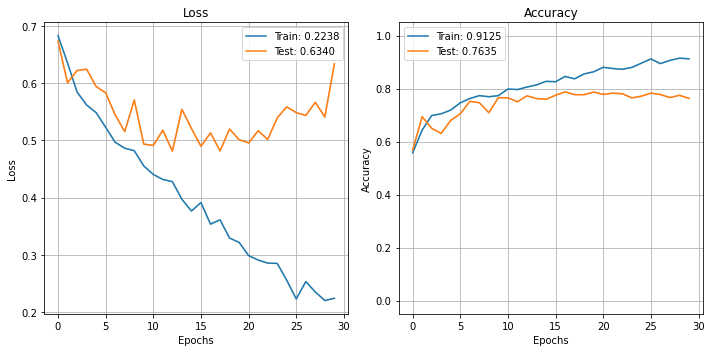

In [36]:
plot_history(history.history)   # this is from plot_keras_history

In [37]:
X_Test = db4['X_Test']
y_Test = db4['y_Test']

In [38]:
score, acc = modelLSTM1.evaluate(X_Test,y_Test,verbose=0)

In [39]:
print(f'test data loss {score:0.4f}, test data accuracy {acc:0.4f}')

test data loss 0.6340, test data accuracy 0.7538


In [40]:
testProbs=modelLSTM1.predict_proba(X_Test)

Instructions for updating:
Please use `model.predict()` instead.


In [41]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)

In [42]:
# looking at some of the data in y_test and comparing to probabilities obtained from predictions (bounded by [0,1])
y_Test[:10]
testProbs[:10]

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1])

array([[0.7174619 ],
       [0.13904923],
       [0.04555964],
       [0.00226825],
       [0.25858372],
       [0.3116844 ],
       [0.03760171],
       [0.70698047],
       [0.13934079],
       [0.9638245 ]], dtype=float32)

In [43]:
# concatenating 1-testprobs and testprobs to give probability predictions of belonging to either class

probs2Classes=np.concatenate((1-testProbs,testProbs),axis=1)

probs2Classes[:8,] # displaying a cut of the data

array([[0.28253812, 0.7174619 ],
       [0.86095077, 0.13904923],
       [0.95444036, 0.04555964],
       [0.99773175, 0.00226825],
       [0.7414163 , 0.25858372],
       [0.68831563, 0.3116844 ],
       [0.9623983 , 0.03760171],
       [0.29301953, 0.70698047]], dtype=float32)

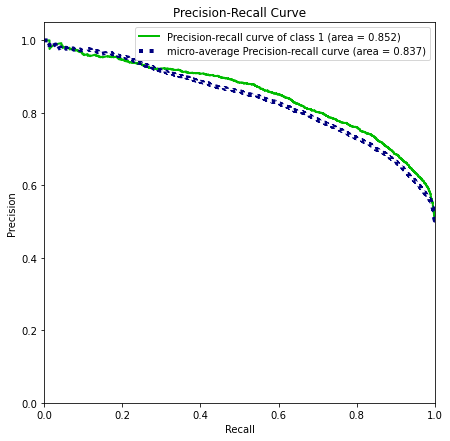

In [44]:
skplt.metrics.plot_precision_recall(y_Test, probs2Classes,
                                         classes_to_plot=[1]); # precision-recall curve plot

The precision-recall curve has area equal to around .85 indicating that this model is fairly good at classifying review sentiment.

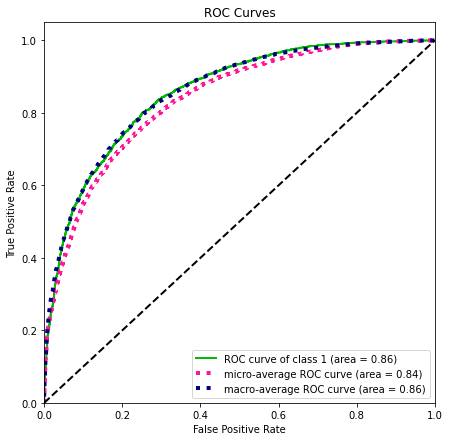

In [45]:
skplt.metrics.plot_roc(y_Test,probs2Classes,classes_to_plot=[1]);

The ROC Curve has an AUC equal to .86 indicating that once again, this model is far better than random chance at classifying reviews (a perfect classifier would have an AUC of 1). 

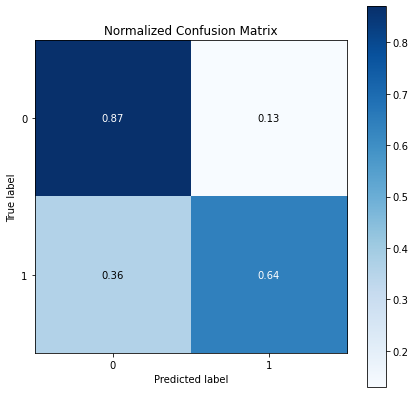

In [46]:
skplt.metrics.plot_confusion_matrix(y_Test,(testProbs>0.50).astype(int), normalize=True);

The confusion matrix indicates that this model is better at identifying true negatives than true positives. It seems to have a higher rate of false negatives but has a corresponding low rate of false positives. In essence, this model is better at identifying negative reviews for being negative than positive reviews for being positive, this could be due to negative language being more apparent in reviews while words like "good" that could be consistenly used in a positive review take on an ambivalent meaning as a negative review might include them in the sense that the movie was "not good". The model seems to perform adequately.

## Part B Using Embeddings Obtained from Autoencoder

In [388]:
os.chdir('C:\\Users\\Wyatt\\Documents\\Assignment4\\Assignment4\\movies\\')

In [390]:
db4b=PickleShareDB('assign4BB.pshare') #loading data saved from part 1

db4b.keys() #data in db4b

['X_TestEm', 'X_TrainEm', 'X_ValEm']

In [428]:
X_TestEm = db4b['X_TestEm']
X_TrainEm = db4b['X_TrainEm']
X_ValEm = db4b['X_ValEm']

In [432]:
X_TrainEm = X_TrainEm.reshape(2000,1,64) #reshaping the data
X_TestEm = X_TestEm.reshape(6000,1,64) #reshaping the data
X_ValEm = X_ValEm.reshape(6000,1,64) #reshaping the data

In [392]:
tf.keras.backend.clear_session()

In [434]:
modelLSTM2=Sequential()
modelLSTM2.add(Bidirectional(LSTM(64, activation="sigmoid", input_shape=(1,64), return_sequences=False)))
modelLSTM2.add(Dense(64))
modelLSTM2.add(LeakyReLU(alpha=0.05))
modelLSTM2.add(Dense(1,activation='sigmoid'))

In [435]:
adam = keras.optimizers.Adam(lr=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-8) # instantiating the optimizer
modelLSTM2.compile(
    optimizer=adam,
    loss='binary_crossentropy',
    metrics=['acc'],
    )

In [436]:
history=modelLSTM2.fit(X_TrainEm, y_Train,
        epochs=30,
        batch_size=32,
        validation_data=(X_ValEm,y_Val),
        verbose=0,
        callbacks=[tensorflow_callback])

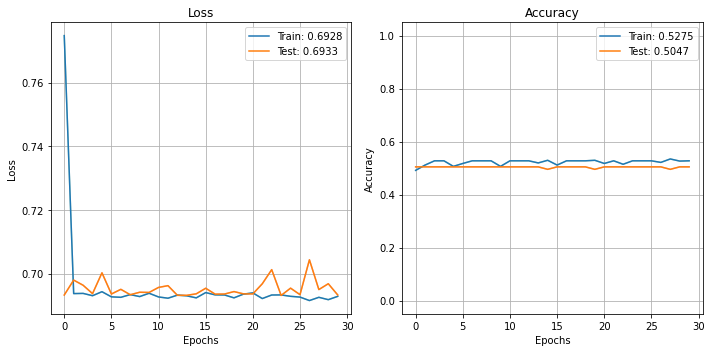

In [418]:
plot_history(history.history) 

In [419]:
score, acc = modelLSTM2.evaluate(X_TestEm,y_Test,verbose=0)

In [420]:
print(f'test data loss {score:0.4f}, test data accuracy {acc:0.4f}')

test data loss 0.6935, test data accuracy 0.4995


In [439]:
testProbs=modelLSTM2.predict_proba(X_TestEm)

In [440]:
probs2Classes=np.concatenate((1-testProbs,testProbs),axis=1)

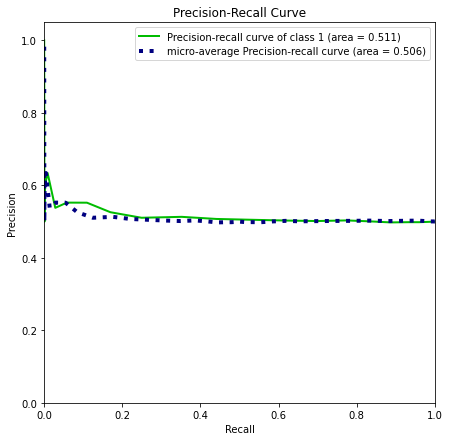

In [441]:
skplt.metrics.plot_precision_recall(y_Test, probs2Classes,
                                         classes_to_plot=[1]); # precision-recall curve plot

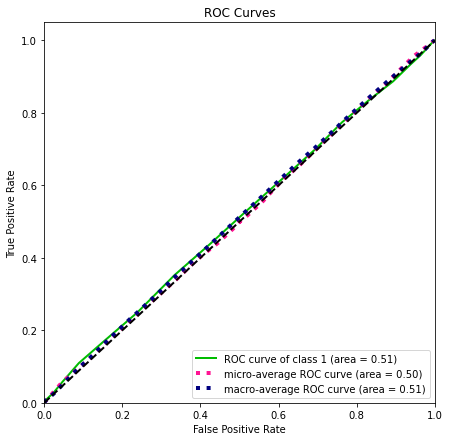

In [442]:
skplt.metrics.plot_roc(y_Test,probs2Classes,classes_to_plot=[1]);

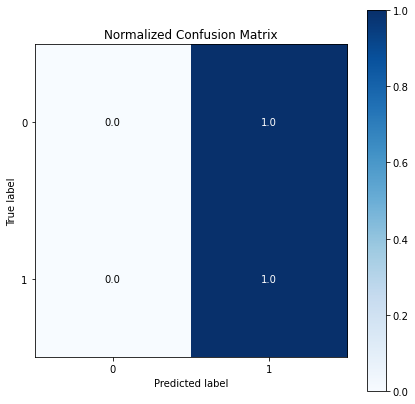

In [443]:
skplt.metrics.plot_confusion_matrix(y_Test,(testProbs>0.5).astype(int), normalize=True);

Despite adding multiple layers and altering the autoencoder several times, trying different activation, etc. I was unable to produce anything but a model that only predicts Positive Sentiment using the data produced in part 1.